In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import build_ongoing_points_table, find_optimal_threshold

In [2]:
df = pd.read_csv('E0.csv')
print(f"Shape of dataset {df.shape}")
df.head()


Shape of dataset (366, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


# Target Variable

As per the goal of the project, we need to predict succesfully if the Away team can win or not.

In [3]:
df['Result'] = (df['FTR'] == 'A').astype(int)

## Converting to Standard Time format

In [4]:
df['Datetime'] = df['Date'] + " " + df['Time']+":00"
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True)
min_date = df['Datetime'].min()
df['Week No.'] = df['Datetime'].apply(lambda x: int((x - min_date).days / 7))

# Generating Features from Analysis 2 notebook

Let us extract the ongoing Points Table score & Custom team form value.
We will also calculate the difference Points as `Point Diff` and the Form difference as `Form Diff 1` & `Form Diff 2`.

The function is available in utils.py, and it is the same as the `build_ongoing_points_table` function from analysis 2. We also have the threshold values calculated.

In [5]:
elite_teams = [
    'Man United', 'Chelsea', 'Tottenham', 'Liverpool', 'Man City', 'Arsenal'
]
Teams = df['HomeTeam'].unique().tolist()
df = build_ongoing_points_table(df, Teams, elite_teams)
df['Point Diff'] = df['AwayPoint'] - df['HomePoint']
df['Form Diff 1'] = df['AwayForm1'] - df['HomeForm1']
df['Form Diff 2'] = df['AwayForm2'] - df['HomeForm2']

point_diff_acc, point_diff_thres = find_optimal_threshold(df, 'Point Diff')
form_diff_acc1, form_diff_thres1 = find_optimal_threshold(df, 'Form Diff 1')
form_diff_acc2, form_diff_thres2 = find_optimal_threshold(df, 'Form Diff 2')

For Point Diff at threshold 14.0, we get accuracy 0.7049180327868853
For Form Diff 1 at threshold 2.0, we get accuracy 0.6967213114754098
For Form Diff 2 at threshold 9.0, we get accuracy 0.7049180327868853


# Betting Houses

In our Dataset, we have given Odds by different Betting Houses (Bet365, Bet&Win, Interwetten, Pinnacle, VC Bet, William Hill). We also have information about the Average & Maximum odds placed by these houses.

Additional information is also given about Closing Odds, which might be slightly different depending on the line ups.

In [6]:
betting_houses = {
    'Bet365': ['B365H', 'B365D', 'B365A'],
    'Bet&Win': ['BWH', 'BWD', 'BWA'],
    'Interwetten': ['IWH', 'IWD', 'IWA'],
    'Pinnacle': ['PSH', 'PSD', 'PSA'],
    'VC Bet': ['VCH', 'VCD', 'VCA'],
    'William Hill': ['WHH', 'WHD', 'WHA'],
    'Average': ['AvgH', 'AvgD', 'AvgA'],
    'Maximum': ['MaxH', 'MaxD', 'MaxA']
}

betting_houses_closing = {
    'Bet365': ['B365CH', 'B365CD', 'B365CA'],
    'Bet&Win': ['BWCH', 'BWCD', 'BWCA'],
    'Interwetten': ['IWCH', 'IWCD', 'IWCA'],
    'Pinnacle': ['PSCH', 'PSCD', 'PSCA'],
    'VC Bet': ['VCCH', 'VCCD', 'VCCA'],
    'William Hill': ['WHCH', 'WHCD', 'WHCA'],
    'Average': ['AvgCH', 'AvgCD', 'AvgCA'],
    'Maximum': ['MaxCH', 'MaxCD', 'MaxCA']
}


# Understanding Odds

Each betting house provides the Odds for each Outcome of a football Match. 
Ex- 
Lets say we are given a betting odds,

Home Odds- 4.0, Away Odds - 1.95, Draw Odds - 3.40. 

If we bet 100Rs on Home Odds, we will give get 400 Rs if Home Team wins otherwise 0.
These Odds can be converted to probablity by taking their reciprocal,

$Probablity of Home Winning = \frac{1}{Home Odds} = \frac{1}{4.0} = 0.25$

$Probablity of Away Winning = \frac{1}{Away Odds} = \frac{1}{1.95} = 0.29$

$Probablity of Draw = \frac{1}{Draw Odds} = \frac{1}{3.40} = 0.51$

$Total Probablity = (Prob of Home) + (Prob of Away) + (Prob of Draw) = 1.05 \neq 1.00$

This 0.05 is intentionally added by Bookies for their own profit. We need to normalize the probablity with Total probablity to get actual values.

Resources - 
1. [The Math Behind Betting Odds and Gambling](https://www.investopedia.com/articles/dictionary/042215/understand-math-behind-betting-odds-gambling.asp)
2. [A beginner’s guide to betting on football 2022](https://www.telegraph.co.uk/betting/sports-guides/football-betting-guide/#:~:text=Odds%20are%20set%20by%20a,which%20you%20prefer%20to%20use.)


In [7]:
for houses in betting_houses:
    df[houses+'_total_prob'] = 0.0
    for keys in betting_houses[houses]:
        df[keys + '_false_prob'] = df[keys].apply(lambda x: 1/x)
        df[houses+'_total_prob'] += df[keys + '_false_prob']
    
    for keys in betting_houses[houses]:
        df[keys + ' Prob'] = df[keys + '_false_prob'] / df[houses+'_total_prob']
    
    df.drop([keys + '_false_prob' for keys in betting_houses[houses]] + [houses+'_total_prob'], axis=1)

for houses in betting_houses_closing:
    df[houses+'_total_prob'] = 0.0
    for keys in betting_houses_closing[houses]:
        df[keys + '_false_prob'] = df[keys].apply(lambda x: 1/x)
        df[houses+'_total_prob'] += df[keys + '_false_prob']
    
    for keys in betting_houses_closing[houses]:
        df[keys + ' Prob'] = df[keys + '_false_prob'] / df[houses+'_total_prob']
    
    df.drop([keys + '_false_prob' for keys in betting_houses_closing[houses]] + [houses+'_total_prob'], axis=1)



As expected, the prediction results of Closing Odds are slightly better than Initial Betting Odds. A plausible explanation is that Bookies have more information about the Team Lineups and other surrounding factors that could affect the game's outcome.

We have used the following scoring - 

$Prediction of Away Win = 
\begin{cases}
  1 & \text{if argmax(Prob of Away, Prob of Home, Prob of Draw) =  Prob of Away}\\
  0 & \text{Else}\\
\end{cases}$

In [8]:
preds = []
closing_preds = []
for houses in betting_houses:
    codes = betting_houses[houses]
    df[houses + ' Result'] = ((df[codes[2] + ' Prob'] > df[codes[0] + ' Prob']) & (df[codes[2] + ' Prob'] > df[codes[1] + ' Prob'])).astype(int)
    preds.append((df[houses + ' Result'] == df['Result']).mean())
    # print(f"Prediction Rate {houses} = {(df[houses + ' Result'] == df['Result']).mean()}")

for houses in betting_houses_closing:
    codes = betting_houses_closing[houses]
    df[houses + ' Closing Result'] = ((df[codes[2] + ' Prob'] > df[codes[0] + ' Prob']) & (df[codes[2] + ' Prob'] > df[codes[1] + ' Prob'])).astype(int)
    closing_preds.append((df[houses + ' Closing Result'] == df['Result']).mean())
    # print(f"Prediction Rate {houses} = {(df[houses + ' Closing Result'] == df['Result']).mean()}")

results_df = pd.DataFrame({"Houses": betting_houses.keys(), "Prediction rate": preds, "Closing Prediction Rate": closing_preds})
results_df

,Houses,Prediction rate,Closing Prediction Rate
0,Bet365,0.729508,0.740437
1,Bet&Win,0.726776,0.740437
2,Interwetten,0.721311,0.743169
3,Pinnacle,0.724044,0.737705
4,VC Bet,0.724044,0.740437
5,William Hill,0.724044,0.737705
6,Average,0.721311,0.743169
7,Maximum,0.721311,0.740437


---

We have used the following scoring - 

$Prediction of Away Win = 
\begin{cases}
  1 & \text{if (Prob of Away) > (Prob of Home + Prob of Draw)}\\
  0 & \text{Else}\\
\end{cases}$

In [9]:
preds = []
closing_preds = []

for houses in betting_houses:
    codes = betting_houses[houses]
    df[houses + ' Result'] = (df[codes[2] + ' Prob'] > (df[codes[0] + ' Prob'] + df[codes[1] + ' Prob'])).astype(int)
    preds.append((df[houses + ' Result'] == df['Result']).mean())

for houses in betting_houses_closing:
    codes = betting_houses_closing[houses]
    df[houses + ' Closing Result'] = (df[codes[2] + ' Prob'] > (df[codes[0] + ' Prob'] + df[codes[1] + ' Prob'])).astype(int)
    closing_preds.append((df[houses + ' Closing Result'] == df['Result']).mean())

results_df = pd.DataFrame({"Houses": betting_houses.keys(), "Prediction rate": preds, "Closing Prediction Rate": closing_preds})
results_df

,Houses,Prediction rate,Closing Prediction Rate
0,Bet365,0.726776,0.729508
1,Bet&Win,0.729508,0.726776
2,Interwetten,0.724044,0.726776
3,Pinnacle,0.734973,0.724044
4,VC Bet,0.732240,0.724044
5,William Hill,0.729508,0.729508
6,Average,0.732240,0.726776
7,Maximum,0.732240,0.729508


# Comparison of Betting Houses and Our Formulation

It is nice to see that we have achieved a similar accuracy as the Baseline Model, which uses Point Difference and Current Form difference of two Teams.

We achieved an accuracy of approx (70%) and Betting Houses hit accuracy of (72%)

# Distribution of Odds

Before we go ahead to further analyse the probabilities of Betting Houses, it would be interesting to see the distribution of Odds provided by different agencies.

If our model learns to predict accurately during a High Odds situation, then we could also have some higher returns.

As Expected, Away Odds tend to be higher than usual.


In [10]:
df[betting_houses['Average']].describe()

,AvgH,AvgD,AvgA
count,366.000000,366.000000,366.000000
mean,3.106093,4.235683,4.712923
std,2.491731,1.360724,4.369180
min,1.110000,3.050000,1.170000
25%,1.670000,3.410000,2.252500
50%,2.335000,3.705000,3.215000
75%,3.340000,4.480000,5.475000
max,18.090000,10.580000,25.830000


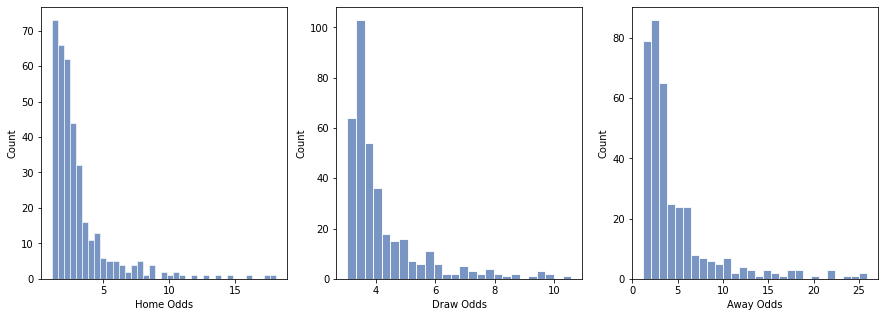

In [11]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.set_theme(style="whitegrid")
ax = sns.histplot(df[betting_houses['Average'][0]], ax=axes[0])
ax.set(xlabel='Home Odds')
ax = sns.histplot(df[betting_houses['Average'][1]], ax=axes[1])
ax.set(xlabel='Draw Odds')
ax = sns.histplot(df[betting_houses['Average'][2]], ax=axes[2])
ax.set(xlabel='Away Odds')
plt.show()

---

Lets Try to Understand the correlation of probablities between Betting Houses (Both Opening & Closing),

They seem to be highly correlated, with the lowest indicated as Dark Black spot with value 0.9984


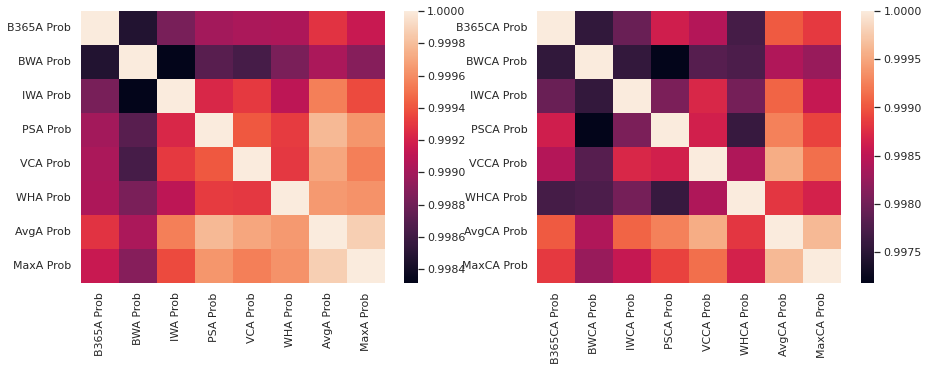

In [12]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

data_smp = df[[betting_houses[codes][2] + ' Prob'for codes in betting_houses]]
dataplot1 = sns.heatmap(data_smp.corr(), ax=axes[0])

data_smp = df[[betting_houses_closing[codes][2] + ' Prob'for codes in betting_houses_closing]]
dataplot2 = sns.heatmap(data_smp.corr(), ax=axes[1])
# plt.show()

Let us also track how different the opening and closing probabilities are. We might be able to use this information to relate to matches where performance was unexpected.

'Bet&Win' and 'Interwetten' seem to have the highest mean difference in closing & opening probabilities

In [13]:
features_names = [houses + ' Away Prob Diff' for houses in betting_houses]
for houses in betting_houses:
    df[houses + ' Away Prob Diff'] = df[betting_houses_closing[houses][2] + ' Prob'] - df[betting_houses[houses][2] + ' Prob']

df[features_names].describe()

,Bet365 Away Prob Diff,Bet&Win Away Prob Diff,Interwetten Away Prob Diff,Pinnacle Away Prob Diff,VC Bet Away Prob Diff,William Hill Away Prob Diff,Average Away Prob Diff,Maximum Away Prob Diff
count,366.000000,366.000000,363.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,-0.001044,-0.002343,-0.002108,-0.000629,-0.001369,-0.000488,-0.001454,-0.002000
std,0.025448,0.022119,0.022830,0.025163,0.023531,0.020746,0.022628,0.022983
min,-0.086493,-0.084599,-0.077034,-0.087193,-0.082602,-0.075064,-0.080781,-0.073059
25%,-0.014512,-0.012755,-0.015861,-0.014564,-0.014091,-0.010508,-0.012546,-0.014434
50%,0.000000,0.000000,-0.000422,0.000141,0.000279,0.000000,-0.000750,-0.001886
75%,0.013619,0.008720,0.012809,0.013376,0.013201,0.010275,0.012070,0.012148
max,0.100920,0.095856,0.094881,0.102943,0.093366,0.113902,0.111964,0.122030


# Error Analysis of Betting Houses

Lets try looking at all instances where Betting Odds seem to fail to give out the correct results

In [14]:
HouseName = 'Bet365'
codes = betting_houses[HouseName]
df[HouseName + ' Result'] = ((df[codes[2] + ' Prob'] > df[codes[0] + ' Prob']) & (df[codes[2] + ' Prob'] > df[codes[1] + ' Prob'])).astype(int)
codes = betting_houses_closing[HouseName]
df[HouseName + ' Closing Result'] = ((df[codes[2] + ' Prob'] > df[codes[0] + ' Prob']) & (df[codes[2] + ' Prob'] > df[codes[1] + ' Prob'])).astype(int)

df[HouseName + ' match'] = (df[houses + ' Result'] == df['Result']).astype(int)
df[HouseName + ' close match'] = (df[houses + ' Closing Result'] == df['Result']).astype(int)

Correct_df = df[df[HouseName + ' match'] == 1]
Correct_close_df = df[df[HouseName + ' close match'] == 1]
Error_df = df[df[HouseName + ' match'] == 0]
Error_close_df = df[df[HouseName + ' close match'] == 0]


## Lets try looking for where Betting Odds seem to perform well

1. Betting Odds seem to predict well when Elite Teams are playing Home
2. Betting Odds seem to perform poorly when Elite Teams are playing Away


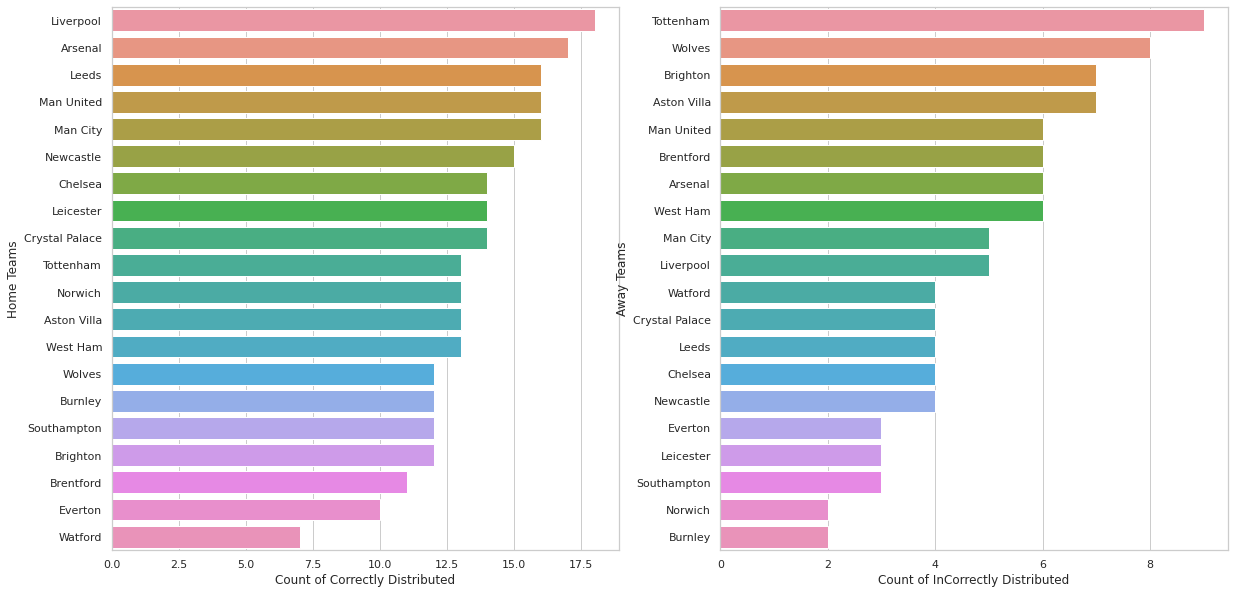

In [15]:
f, axes = plt.subplots(1, 2, figsize=(20,10))

ax = sns.barplot(x="HomeTeam", y="index",data=Correct_df['HomeTeam'].value_counts().reset_index(), ax=axes[0])
ax.set_ylabel("Home Teams")
ax.set_xlabel("Count of Correctly Distributed")

ax = sns.barplot(x="AwayTeam", y="index",data=Error_df['AwayTeam'].value_counts().reset_index(), ax=axes[1])
ax.set_ylabel("Away Teams")
ax.set_xlabel("Count of InCorrectly Distributed")
plt.show()

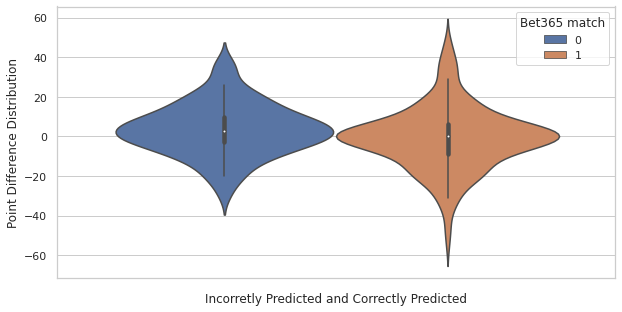

In [16]:
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Point Diff", hue=HouseName + ' match', data=df)
ax.set_ylabel("Point Difference Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

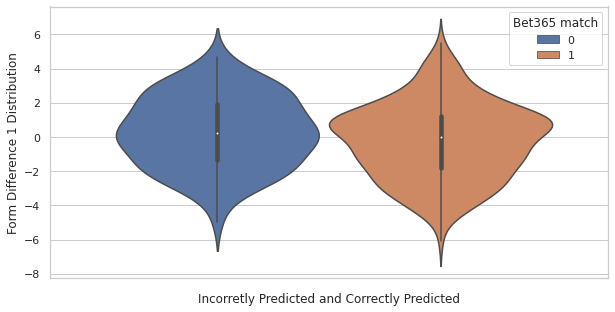

In [17]:
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Form Diff 1", hue=HouseName + ' match', data=df)
ax.set_ylabel("Form Difference 1 Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

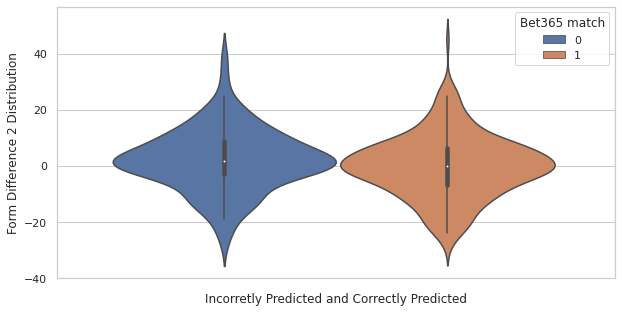

In [18]:
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Form Diff 2", hue=HouseName + ' match', data=df)
ax.set_ylabel("Form Difference 2 Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

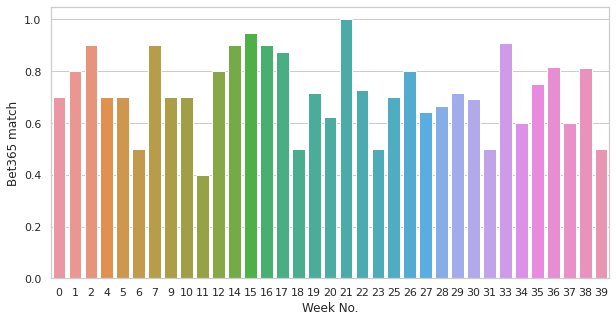

In [19]:
week_results = df.groupby(['Week No.'])[HouseName + ' match'].mean().reset_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Week No.", y=HouseName + ' match',data=week_results)
plt.show()

In [20]:
### To get count of number of matches per week, uncomment this line

# week_results = df['Week No.'].value_counts().reset_index().sort_values(by="index")
# plt.figure(figsize=(10,5))
# sns.barplot(x="index", y='Week No.',data=week_results)
# plt.show()
